In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context('talk')

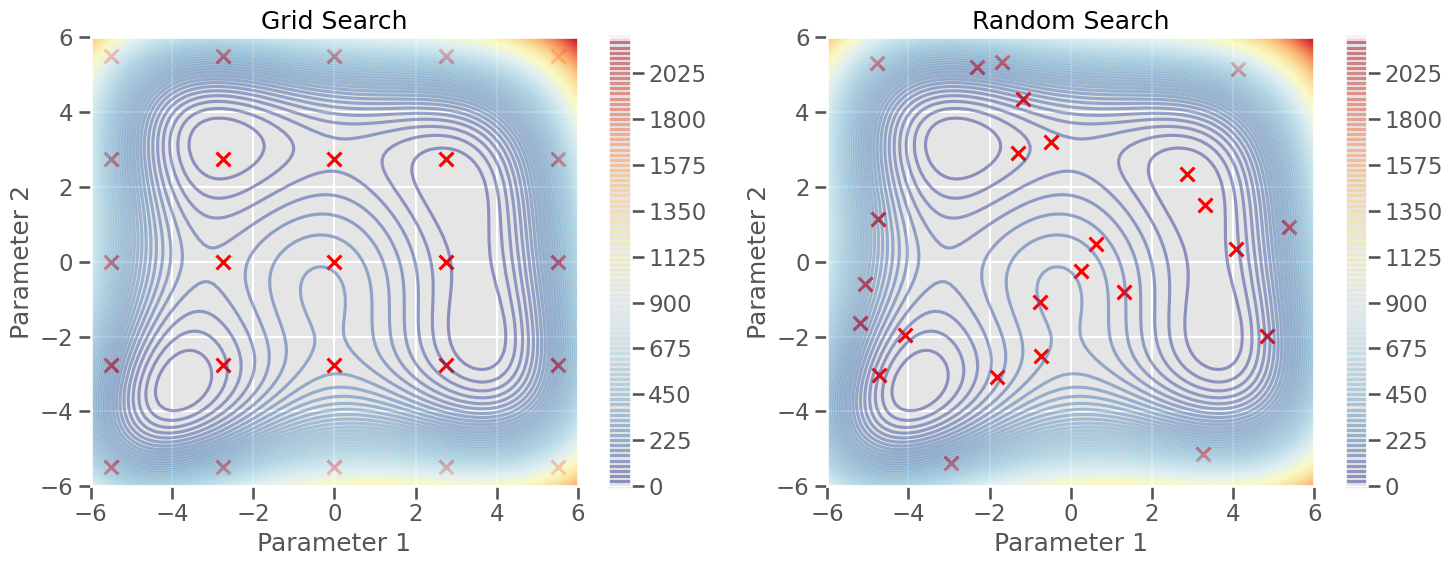

In [37]:
import numpy as np

# Create a function to simulate an objective function with a clear optimum
def objective_function(x, y):
    """Simulates an objective function with a global minimum."""
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2  # Himmelblau's function

# Create parameter space
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = objective_function(X, Y)

# Generate search points
np.random.seed(8)
n_points = 25  # Use 25 points for a 5x5 grid

# Grid search points
grid_x = np.linspace(-5.5, 5.5, int(np.sqrt(n_points)))
grid_y = np.linspace(-5.5, 5.5, int(np.sqrt(n_points)))
grid_points = np.array([(x, y) for x in grid_x for y in grid_y])

# Random search points - use same number of points as grid search
random_points = np.random.uniform(
    low=[-5.5, -5.5], 
    high=[5.5, 5.5], 
    size=(n_points, 2)  # 25 points to match grid search
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Grid Search
contour1 = ax1.contour(X, Y, Z, levels=100, cmap='RdYlBu_r', alpha=0.5)  # Added alpha=0.5
ax1.scatter(grid_points[:, 0], grid_points[:, 1], color='red', marker='x', s=100, label='Search points')
ax1.set_title('Grid Search')
ax1.set_xlabel('Parameter 1')
ax1.set_ylabel('Parameter 2')
fig.colorbar(contour1, ax=ax1)

# Plot Random Search
contour2 = ax2.contour(X, Y, Z, levels=100, cmap='RdYlBu_r', alpha=0.5)  # Added alpha=0.5
ax2.scatter(random_points[:, 0], random_points[:, 1], color='red', marker='x', s=100, label='Search points')
ax2.set_title('Random Search')
ax2.set_xlabel('Parameter 1')
ax2.set_ylabel('Parameter 2')
fig.colorbar(contour2, ax=ax2)

plt.tight_layout()
plt.show()


In [46]:
# Adaptive sampling based on loss values
import numpy as np
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create grid for visualization
x_grid = np.linspace(-6, 6, 100)  # Expanded x range
y_grid = np.linspace(-6, 6, 100)  # Expanded y range
grid_x, grid_y = np.meshgrid(x_grid, y_grid)
Z = objective_function(grid_x, grid_y)

# Use the random search points from before
random_points = random_points.copy()  # Initial random samples
bayesian_points = np.empty((0,2))  # Will store Bayesian samples
random_values = np.array([objective_function(x[0], x[1]) for x in random_points])
bayesian_values = np.array([])

# Create figure and axis that will be reused
fig, ax = plt.subplots(figsize=(10, 8))

# Create contour plot once and store colorbar
contour = ax.contour(grid_x, grid_y, Z, levels=100, cmap='RdYlBu_r', alpha=0.5)
colorbar = plt.colorbar(contour, label='Loss Value')

def update(frame):
    global bayesian_points, bayesian_values
    
    # Clear the axis but keep the colorbar
    ax.clear()
    
    # Replot contour without new colorbar
    contour = ax.contour(grid_x, grid_y, Z, levels=100, cmap='RdYlBu_r', alpha=0.5)
    
    # Plot existing points
    ax.scatter(random_points[:, 0], random_points[:, 1], c='red', marker='x', s=100, 
              label='Random Samples')
    if len(bayesian_points) > 0:
        ax.scatter(bayesian_points[:, 0], bayesian_points[:, 1], c='blue', marker='o', s=100,
                  label='Bayesian Samples', alpha=0.5)
    
    # Sample new points using a mixture of exploitation and exploration
    if len(bayesian_points) == 0:
        # First iteration uses random points
        values = random_values
        points = random_points
    else:
        # Subsequent iterations use all points
        values = np.concatenate([random_values, bayesian_values])
        points = np.vstack([random_points, bayesian_points])
    
    # Calculate weights for exploitation (focusing on good points)
    exploit_weights = 1.0 / (values - np.min(values) + 1e-6)
    exploit_weights = exploit_weights / np.sum(exploit_weights)
    
    # Mix exploitation with exploration
    explore_weights = np.ones_like(values) / len(values)  # Uniform weights for exploration
    
    # Combine weights (70% exploitation, 30% exploration)
    weights = 0.7 * exploit_weights + 0.3 * explore_weights
    weights = weights / np.sum(weights)
    
    # Choose parent points based on combined weights
    parent_indices = np.random.choice(
        len(points), 
        size=1,  # points_per_iter
        p=weights
    )
    
    # Add noise to parent points to get new samples
    # Scale noise based on iteration (decreasing over time)
    noise_scale = 0.2 * (1 - frame/15)  # Reduces from 0.2 to 0
    new_points = points[parent_indices] + np.random.normal(0, noise_scale, (1, 2))
    
    # Clip to bounds
    new_points = np.clip(new_points, [-5.5, -5.5], [5.5, 5.5])  # Expanded bounds
    
    # Add new points to Bayesian samples
    bayesian_points = np.vstack([bayesian_points, new_points])
    new_values = np.array([objective_function(x[0], x[1]) for x in new_points])
    bayesian_values = np.append(bayesian_values, new_values)
    
    ax.set_title(f'Iteration {frame+1}')
    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.legend()
    
    return ax,

# Create animation
anim = animation.FuncAnimation(fig, update, frames=15, interval=500, blit=False)

# Save animation
anim.save('bayesian_optimization.gif', writer='pillow')
plt.close()
